# Capstone Project - Training center location selection
### Applied Data Science Capstone by IBM/Coursera

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium.plugins import HeatMap

from bs4 import BeautifulSoup
import html5lib

import pickle

print('Libraries imported.')

Libraries imported.


In [2]:
CLIENT_ID = 'TWQNBUQDQIII1KZJ0RTLFNG0NR15AVJIZU5KFPHM3ANEHMHU' # Foursquare ID
CLIENT_SECRET = 'VD0GO1D1LCR1T5GYDJHBVXS4REOQD4KVWSADZAZGKXOAQ1DU' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Getting latitude and longitude of Montreal

In [3]:
address = 'Montreal'

geolocator = Nominatim(user_agent="mtl_explorer")
location = geolocator.geocode(address)
latitude_mtl = location.latitude
longitude_mtl = location.longitude

## Search for Gym/Fitness venue categories in the Montreal area: 

In [4]:
# Will the data be loaded from local files or built up through Foursquare:
load = True # (1:yes, 0:no)

In [5]:
gym_fitness = '4bf58dd8d48988d175941735' # Root id for all fitness and training facilities

categoryId = {'Boxing Gym':'52f2ab2ebcbc57f1066b8b47', 'Gym': '4bf58dd8d48988d176941735', 'Martial Arts School': '4bf58dd8d48988d101941735', 'Outdoor Gym': '58daa1558bbb0b01f18ec203'} # Category IDs for Boxing Gyms, Gyms, Martial Arts Dojos and outdoor gyms

radius = 26000 # Radius in which to search relative to the center of Montreal
LIMIT = 10000 # Limit of the number of venues to fetch

In [6]:
gym_df = pd.DataFrame()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

if not load:
    # Loop over the different category ids and search for the corresponding venues in the montreal area. Data will be stored in the gym_df dataframe:
    for key_cat in categoryId:
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_mtl, longitude_mtl, VERSION, categoryId[key_cat], radius, LIMIT)

        results = requests.get(url).json()

        # assign relevant part of JSON to venues
        venues = results['response']['venues']

        # tranform venues into a dataframe
        dataframe = json_normalize(venues)

        # keep only columns that include venue name, and anything that is associated with location
        filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
        dataframe_filtered = dataframe.loc[:, filtered_columns]

        # filter the category for each row
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

        # clean column names by keeping only last term
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

        gym_df = gym_df.append(dataframe_filtered)

    gym_df.drop_duplicates(subset='id', keep="last", inplace= True)
    gym_df.head()

In [7]:
# This will run when we want to load the file locally instead of goign through foursquare:
if load:
    with open('./Gym_dataframe.pkl', 'rb') as f:
        gym_df = pickle.load(f) 
gym_df.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,UnderDog Boxing Gym,Boxing Gym,9 Ste-Catherine East,St-Laurent,45.510055,-73.563710,"[{'label': 'display', 'lat': 45.51005460345811...",3910,Ca,CA,Montréal,QC,Canada,"[9 Ste-Catherine East (St-Laurent), Montréal Q...",NaN,4b6f9c10f964a520c6f72ce3
1,Club de Boxe de d'Est,Boxing Gym,2350 Rue Dickson,NaN,45.567281,-73.537101,"[{'label': 'display', 'lat': 45.56728097321409...",9668,H1N 3T1,CA,Montréal,QC,Canada,"[2350 Rue Dickson, Montréal QC H1N 3T1, Canada]",NaN,5241fdde11d28e28a9ad23c1
2,Club de boxe Titan,Boxing Gym,6777 rue Saint-André,NaN,45.538636,-73.607155,"[{'label': 'display', 'lat': 45.53863644534114...",4617,H2S 2L1,CA,Montréal,QC,Canada,"[6777 rue Saint-André, Montréal QC H2S 2L1, Ca...",NaN,4cfd91a920fe3704236260f8
3,Muay Thai,Boxing Gym,NaN,NaN,45.500788,-73.424580,"[{'label': 'display', 'lat': 45.500788, 'lng':...",14501,NaN,CA,NaN,NaN,Canada,[Canada],NaN,589cfde6e7f1cf49872a982d
4,apex,Boxing Gym,1827 St-Catherine W.,St-Marc,45.493524,-73.580149,"[{'label': 'display', 'lat': 45.493524, 'lng':...",2393,H3H 1M8,CA,Montréal,QC,Canada,"[1827 St-Catherine W. (St-Marc), Montréal QC H...",NaN,54ee76b3498ecc627d1df2a3


In [8]:
# Looking at the different venue categories obtained:
print('The querry fetched the following categories:')
for cat in gym_df['categories'].unique():
    print('- {}'.format(cat))

The querry fetched the following categories:
- Boxing Gym
- Gym
- Martial Arts School


In [9]:
if not load:
    # Making the categories more uniform:
    gym_df.replace(to_replace = 'Gym / Fitness Center', value = 'Gym', inplace= True)

    # Dropping dataframe rows that have a category that is non relevant for us:
    for cat in gym_df['categories'].unique():
        if cat in categoryId.keys():
            pass
        else:
            gym_df = gym_df[gym_df['categories']!=cat]

    # Looking at the different venue categories obtained:
    print('The querry fetched the following categories:')
    for cat in gym_df['categories'].unique():
        print('- {}'.format(cat))
        
    gym_df.to_pickle('./Gym_dataframe.pkl')

Text(0, 0.5, 'Frequency')

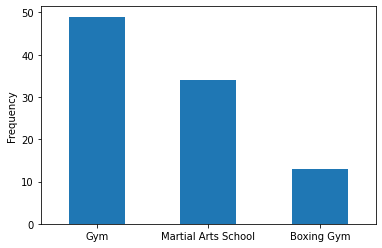

In [10]:
# Plot the frequency of each category:
gym_df['categories'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)
plt.ylabel('Frequency')

In [11]:
# Color map to asociate a color for each category venue:
venue_colormap = {
    'Boxing Gym':'red', 
    'Gym': 'blue', 
    'Martial Arts School': 'black',
    'Outdoor Gym': 'yellow'
}

In [12]:
mtl_map = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)
for lat, lon, name, cat in zip(gym_df['lat'],gym_df['lng'], gym_df['name'], gym_df['categories']):
    label = '{}, ({})'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    try:
        color=venue_colormap[cat]
    except:
        color='grey'
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color = color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(mtl_map)

mtl_map

In [13]:
# Let us plot a heat map to better see the concentration of the trainings:
gym_latlng = [[lat,lng] for lat, lng in zip(list(gym_df['lat']),list(gym_df['lng']))]

mtl_heatmap = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)
folium.TileLayer('cartodbpositron').add_to(mtl_heatmap) #cartodbpositron cartodbdark_matter
HeatMap(gym_latlng).add_to(mtl_heatmap)
mtl_heatmap

## Nearby venues exploration for each gym:

The purpose of this section is as follows :
* Explore the venues around each gym.
* Fetch the ratings and  likes count of each gym.
* Analyse if there is a correlation between the succes and popularity of a training center and the distance relative to specific types of venues.

### Data wrangling and exploratory data analysis:

In [14]:
# This will run when we want to load the file locally instead of goign through foursquare:
if load:
    with open('./Gym_venues_and_rating.pkl', 'rb') as f:
        gym_venues_df = pickle.load(f)
    gym_venues_df.head()

In [15]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

In [16]:
# We define a function that regroups all the steps required to explore a specific venue (get its rating and likes count) as well as get its nearby venues:
# Inputs:
# - gym_name: Name of the gym/fitness center (string)
# - gym_cat: Category under which the training center falls into (string) 
# - venue_id: The id of the gym/training center (string)
# - gym_lat: latitude of the training center (float)
# - gym_lng: longitude of the training center (float)

# Outputs:
# nearby_venues: DataFrame containing the nearby venues of the gym specified as input

def explore_gym_nearby_venues(gym_name, gym_cat, venue_id, gym_lat, gym_lng):

    gym_venues_radius = 500 # We limit the radius of the search to 500m around the training center
    gym_venues_LIMIT = 300 # We limit the nearby venues to 300

    # Setting the url used to explore a specific venue using the venue's id - the goal is to get the rating and likes count:
    gym_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

    gym_results = requests.get(gym_url).json()

    # Assign relevant part of JSON to venues
    venue = gym_results['response']

    # Tranform venues into a dataframe
    dataframe = json_normalize(venue)

    # Getting the rating and likes count of the venue:
    try:
        likes_count= gym_results['response']['venue']['likes']['count']
        # likes_count = dataframe['venue.likes.count'][0]
    except:
        likes_count = -1
        # likes_count = dataframe['venue.likes.count'][0]

    try:
        rating = gym_results['response']['venue']['rating']
        # rating = dataframe['venue.rating'][0]
    except:
        rating = -1
    
    # Setting the url used to explore nearby venues of the training center:
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, gym_lat, gym_lng, VERSION, gym_venues_radius, gym_venues_LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    

    nearby_venues = nearby_venues[filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type,axis=1)

    nearby_venues.columns = map(str.title,[col_name.split('.')[-1] for col_name in nearby_venues.columns])

    nearby_venues.rename(columns={'Name':'Venue Name'}, inplace=True)

    nearby_venues['Gym Name'] = gym_name
    nearby_venues['Gym category'] = gym_cat
    nearby_venues['Gym id'] = venue_id
    nearby_venues['Gym lat'] = gym_lat
    nearby_venues['Gym lng'] = gym_lng
    nearby_venues['Likes count'] = likes_count
    nearby_venues['Rating'] = rating
    print(' .', end='')

    return nearby_venues

In [17]:
if not load:
    # Building the dataframe containing the training centers, their likes count and rating as well as the nearby venues for each training center:
    gym_venues_df = pd.DataFrame()

    for gym_name, gym_cat, gym_id, gym_lat, gym_lng in zip(gym_df['name'], gym_df['categories'], gym_df['id'], gym_df['lat'], gym_df['lng']):
        nearby_venues = explore_gym_nearby_venues(gym_name, gym_cat, gym_id, gym_lat, gym_lng)
        gym_venues_df = gym_venues_df.append(nearby_venues)
    print(' done.')

    # Reordering the dataframe for better readability:
    column_order = list(gym_venues_df.columns[-7:]) + list(gym_venues_df.columns[:-7])
    gym_venues_df = gym_venues_df[column_order]

In [18]:
gym_venues_df.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,Venue Name,Categories,Lat,Lng
0,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Cadet,Restaurant,45.510260,-73.564584
1,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Bouillon Bilk,Restaurant,45.510845,-73.566017
2,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Société des arts technologiques [SAT],Music Venue,45.509369,-73.562654
3,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,Cachitos,Bakery,45.509814,-73.564077
4,UnderDog Boxing Gym,Boxing Gym,4b6f9c10f964a520c6f72ce3,45.510055,-73.56371,15,8.3,La Maison Symphonique de Montréal,Concert Hall,45.509442,-73.566599


In [19]:
# Due to the limit of 500 premium API calls, let us save the dataframe in order to use it instead of having to use Foursquare.
if not load:
    gym_venues_df.to_pickle('./Gym_venues_and_rating.pkl')

In [20]:
print('The total number of training centers found in the Montreal area is: {} gyms'.format(len(gym_venues_df['Gym id'].unique())))

The total number of training centers found in the Montreal area is: 96 gyms


In [21]:
# Let us see the most common venue category that are found nearby the training centers (we look at all the training centers together):
categories_count = gym_venues_df.groupby('Categories').count().sort_values(by='Gym Name', ascending= False)[['Gym Name']]
categories_count.rename(columns={'Gym Name':'Frequency'}, inplace=True)
categories_count.head(25)

,Frequency
Categories,
Café,152
Coffee Shop,131
Restaurant,95
Hotel,78
French Restaurant,65
Bakery,65
Italian Restaurant,64
Sandwich Place,61
Pizza Place,55


In [22]:
# Uncomment to see the number of nearby venues found for each training centers:
nearby_venues_count = gym_venues_df.groupby('Gym id').count().sort_values(by='Gym Name', ascending= False)[['Gym Name']]
nearby_venues_count.rename(columns={'Gym Name':'Number of nearby venues'}, inplace=True)
nearby_venues_count.head(10)

,Number of nearby venues
Gym id,
4f80bf117bebb2e5d3d80743,100
4cdad31a6ad1a093fc7be856,100
4ae47814f964a520c49a21e3,100
4b701dacf964a520c5072de3,100
5a9eaa8aa9fe123ead2a1b4d,100
50f1e1b4e4b067e9ee937823,95
525d6076498ed004aa99834c,94
50a19bb2498efdffc88c2a4d,86
4b2d1304f964a520bdcd24e3,85


In [23]:
gym_venues_df.shape

(2905, 11)

### Plotting Rating/Likes Count/Succes metric versus disctances to specific venues

In [23]:
def normalize(data):
    return (data - data.min())/(data.max() - data.min())

In [24]:
# Function used to compute distances between two latitude and longitude coordinates:

# Inputs:
# - lat1: latitude of first location (float)
# - lon1: longitude of first location (float)
# - lat2: latitude of second location (float)
# - lon1: longitude of second location (float)

# Outputs:
# - distance (float)

def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371 # Earth's radius
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [25]:
# Function that computes the distance between each gym and all the venues that belong to the venue category specified:
# Inputs:
# - cat: venue category to be analyses (string)
# - gym_venues_df: dataframe containing the gyms/training centers and their corresponding nearby venues (pandas dataFrame)

# Outputs:
# - specific_venue_dist: dataframe containing Gym Name, Gym id, rating of the gym, likes count of the gym, Popularity metric of the gym, distance between the gym and all the nearby venues under the category specified. (DataFrame)
# - norm_likes: Weights for likes count to be used in the bubble plot (Pandas Series)

def gym_venue_dist(venue_category,gym_venues_df):
    # venue_category: Choose a specific venue to use during the analysis of the effect of distance on the rating:
    
    # Selecting only the specifi type of venues category of interest:
    specific_venue = gym_venues_df[gym_venues_df['Categories'] == venue_category]

    # Removing training centers for which no rating & likes count are available:
    specific_venue = specific_venue[specific_venue['Rating']!=-1]
    specific_venue = specific_venue[specific_venue['Likes count']!=0].reset_index()

    # Weights for likes count to be used in the bubble plot:
    norm_likes =(specific_venue['Likes count'] - specific_venue['Likes count'].min())/(specific_venue['Likes count'].max() - specific_venue['Likes count'].min())

    # Building a dataframe with a rating column and distance column (distance between the training center and the venues belonging to the specific category of interest)
    columns = ['Gym Name', 'Gym id','Rating', 'Likes count', 'Pop metric', 'Distance']
    specific_venue_dist= pd.DataFrame(columns=columns)
    for index, row in specific_venue.iterrows():
        dist = haversine_distance(row['Gym lat'], row['Gym lng'], row['Lat'], row['Lng'])
        # if dist !=0:
        specific_venue_dist.loc[index] = [row['Gym Name'],row['Gym id'],row['Rating'],float(row['Likes count']),row['Rating']*float(row['Likes count']),dist]
    
    specific_venue_dist['Rating'] = normalize(specific_venue_dist['Rating'])
    specific_venue_dist['Likes count'] = normalize(specific_venue_dist['Likes count'])
    specific_venue_dist['Pop metric'] = normalize(specific_venue_dist['Pop metric'])
    
    return specific_venue_dist, norm_likes

In [27]:
# Repeating the process in a for loop. For each venue category we compute the average distance between the venues and training centers. We will limit ourselved to the 25 most common venue categories.  
# Then we compute the correlation between ratings, likes count, pop(ularity) metric and the avg distance

columns = ['Venue Category', 'Corr.Rating', 'Corr.Likes count', 'Corr.Pop metric']
distance_corr = pd.DataFrame(columns = columns)

for idx, cat in enumerate(list(categories_count.head(25).index)):
    specific_venue_dist = gym_venue_dist(cat, gym_venues_df)[0]

    try:
        specific_venue_avgdist = specific_venue_dist.groupby('Gym id').mean().sort_values(by='Rating', ascending = False)
        corr_matrix = specific_venue_avgdist.corr()
        distance_corr.loc[idx] = [cat,corr_matrix['Distance']['Rating'],corr_matrix['Distance']['Likes count'],corr_matrix['Distance']['Pop metric']]
    except:
        distance_corr.loc[idx] = [cat,None,None,None]
    print(' .', end='')
print(' done.')

. . . . . . . . . . . . . . . . . . . . . . . . . done.


In [28]:
 # We display the correlation of the distance to the 25 most common venue categories with rating, likes count and Pop(ularity) metrics
 distance_corr.sort_values(by='Corr.Pop metric')

,Venue Category,Corr.Rating,Corr.Likes count,Corr.Pop metric
8,Pizza Place,0.271731,-0.694822,-0.681484
20,Asian Restaurant,0.272513,-0.625826,-0.467089
18,Portuguese Restaurant,-0.707687,-0.328950,-0.402140
7,Sandwich Place,-0.168259,-0.290706,-0.313610
15,Pharmacy,-0.187950,-0.235855,-0.259984
5,Bakery,-0.064382,-0.183537,-0.201880
4,French Restaurant,0.120890,-0.162837,-0.184309
13,Gym,-0.103846,-0.162081,-0.165060
21,Clothing Store,0.329882,-0.089151,-0.089261
14,Vietnamese Restaurant,0.070131,-0.075816,-0.057575


In [29]:
# Analyzing a specific venue category that seems promising:

venue_category = 'Gas Station'
specific_venue_dist, norm_likes = gym_venue_dist(venue_category,gym_venues_df)
specific_venue_dist.head()

,Gym Name,Gym id,Rating,Likes count,Pop metric,Distance
0,Nautilus Plus,4ba13fa8f964a520d2a537e3,1.000000,0.270270,0.451524,0.29
1,Centre Sportif De La Petite-Bourgogne,4ba368bdf964a520c63a38e3,0.518519,0.054054,0.062789,0.27
2,YM-YWHA Montreal Jewish Community Centres - Be...,4ad4c06cf964a520f1f920e3,0.703704,0.135135,0.198061,0.25
3,Nautilus Plus,4af89924f964a520960e22e3,0.000000,1.000000,1.000000,0.33
4,Nautilus Plus,4ba2b3ecf964a520c61138e3,0.185185,0.081081,0.052170,0.26


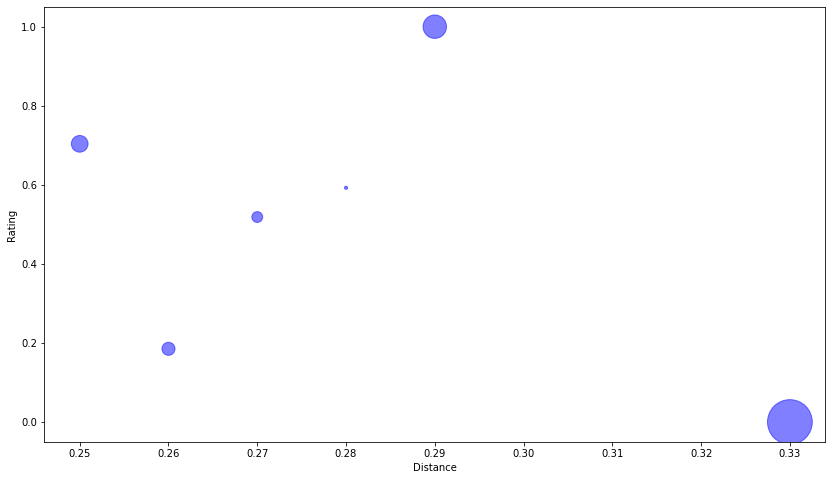

In [30]:
# Plotting the ratings versus the distances to the specific venue category:
specific_venue_dist.plot(kind='scatter',
                    x='Distance',
                    y='Rating',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='blue',
                    s=norm_likes*2000  + 10  # pass in the weights
                    )

# Comments on the analysis of rating = f(distance):
# - See that the more the distance from other gyms/training centers increases rating increases too.

In [31]:
# The dataframe built contains the distances between the training centers and each of their nearby venues that belong to the category specified.
# We now build a dataframe with the average distance of each training center to this category of nearby venues:
specific_venue_avgdist = specific_venue_dist.groupby('Gym id').mean().sort_values(by='Rating', ascending = False)

# Getting the gym names by order of descending ratings
gym_names = specific_venue_dist.drop_duplicates(subset='Gym id').sort_values(by='Rating', ascending = False)[['Gym Name','Gym id']]
gym_names.set_index('Gym id', drop = True, inplace=True)
gym_names.head()

specific_venue_avgdist = gym_names.join(specific_venue_avgdist)
specific_venue_avgdist.rename(columns={'Distance':"Avg.Distance"}, inplace=True)
specific_venue_avgdist.head(20)

,Gym Name,Rating,Likes count,Pop metric,Avg.Distance
Gym id,,,,,
4ba13fa8f964a520d2a537e3,Nautilus Plus,1.000000,0.270270,0.451524,0.29
4ad4c06cf964a520f1f920e3,YM-YWHA Montreal Jewish Community Centres - Be...,0.703704,0.135135,0.198061,0.25
51d9a05b498e309c6e8a84dc,Z Gym,0.592593,0.000000,0.000000,0.28
4ba368bdf964a520c63a38e3,Centre Sportif De La Petite-Bourgogne,0.518519,0.054054,0.062789,0.27
4ba2b3ecf964a520c61138e3,Nautilus Plus,0.185185,0.081081,0.052170,0.26
4af89924f964a520960e22e3,Nautilus Plus,0.000000,1.000000,1.000000,0.33


In [32]:
specific_venue_avgdist[['Rating', 'Likes count', 'Pop metric', 'Avg.Distance']].corr()

,Rating,Likes count,Pop metric,Avg.Distance
Rating,1.000000,-0.534653,-0.361628,-0.392377
Likes count,-0.534653,1.000000,0.979710,0.875230
Pop metric,-0.361628,0.979710,1.000000,0.867469
Avg.Distance,-0.392377,0.875230,0.867469,1.000000


Text(0.5, 1.0, 'Gas Station venue category correlation analysis')

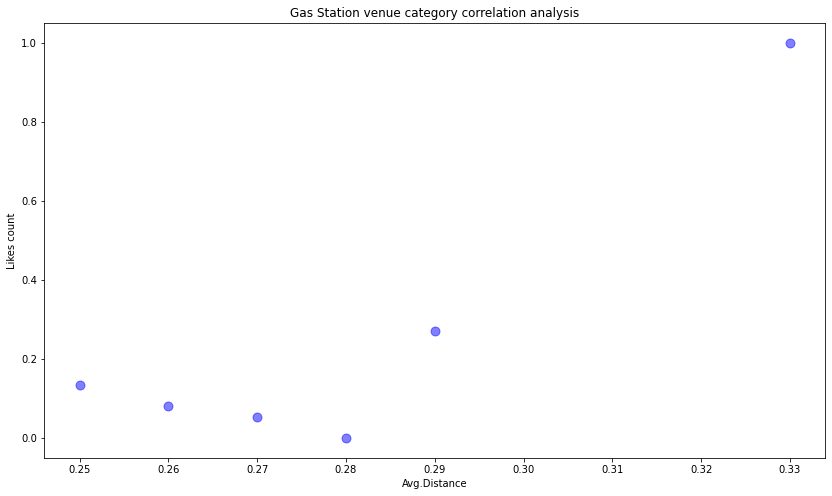

In [33]:
# Plotting the ratings versus the distances to the specific venue category:
specific_venue_avgdist.plot(kind='scatter',
                    x='Avg.Distance',
                    y='Likes count',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='blue',
                    s = 80
                    )
plt.title('{} venue category correlation analysis'.format(venue_category))


### Conclusions:
* The previous section aimed at identifying nearby venues that have seem to have an impact on the succes and popularity of a gym.
* The analysis of some venues gave some interesting insights ()
* However due to the lack of data and the small number of gyms who were rated the analysis could not be applied to some particularily interesting venues such as metro stations, gaz stations, bus stops etc.
* The tool however is ready to be used on any type of venue category provided the data is available.

## One-hot encoding of the nearby venues categories for each Gym:

In [26]:
# One-hot encoding of the nearby venues categories for each Gym base on the venue category:
gym_venues_onehot = pd.get_dummies(gym_venues_df[['Categories']], prefix="", prefix_sep="")
gym_venues_onehot.head()

,ATM,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Football Field,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,W

In [35]:
gym_venues_onehot.shape

(2905, 274)

In [27]:
# Adding relevant columns to the one hot-encoding dataFrame obtained:
gym_onehot_venues = pd.concat([gym_venues_df[gym_venues_df.columns[:-4]],gym_venues_onehot],axis=1)
gym_onehot_venues.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,ATM,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Football Field,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Stor

### Let's group rows by Gym id and by taking the mean of the frequency of occurrence of each category:

In [28]:
# We group Gym by their id since some gyms have the same name but are actually different training facilites:
gym_venues_grouped = gym_onehot_venues.groupby(gym_onehot_venues['Gym id']).mean().reset_index()
gym_venues_grouped.head()

,Gym id,Gym lat,Gym lng,Likes count,Rating,ATM,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Football Field,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietname

In [29]:
# Looking at the shape of the dataframe, we should get as many rows as there are training centers found in the gym_df dataframe:
print('Shape of dataframe {}'.format(gym_venues_grouped.shape))
print('The number of gyms found is: {} gyms'.format(len(gym_venues_df['Gym id'].unique())))

Shape of dataframe (96, 279)
The number of gyms found is: 96 gyms


In [30]:
# Adding a column with the gym names. We have to respect the ascending order of the id.
gym_venues_grouped[['Gym Name', 'Gym category']] = gym_onehot_venues[['Gym Name', 'Gym category', 'Gym id']].sort_values(by='Gym id',ascending=True)[['Gym Name', 'Gym category']].reset_index(drop=True)

# Reordering the columns for better readability
column_order = list(gym_venues_grouped.columns[-2:]) + list(gym_venues_grouped.columns[:-2])
gym_venues_grouped = gym_venues_grouped[column_order]

gym_venues_grouped.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,ATM,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Football Field,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Stor

## Clustering the gyms based on their surrounding venues:

In [31]:
np.random.seed(0)

In [32]:
gym_venues_clustering = gym_venues_grouped[gym_venues_grouped.columns[7:]]

In [33]:
gym_venues_clustering.head()

,ATM,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Football Field,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,W

In [34]:
# Function that applies the elbow method used to choose the best number of clusters to be specified for a dataset.
# Inputs:
# - n_clusters: maximum number of clusters to be tested (int)
# - X: data to be clustered (DataFrame) 

# - Output:
# - tot_avg_distance: avg distance between clusters and their centers

def elbow(n_clusters, X):

    tot_avg_distance = []

    for k in range(1,n_clusters):
        k_means_temp = KMeans(n_clusters=k, random_state=0)
        k_means_temp.fit(X)
        centers_temp = k_means_temp.cluster_centers_ # The size/len of the eanch center array is equal to the number of venue categories found in the gym_venues_clustering
        labels_temp = k_means_temp.labels_

        cluster_avg_dist = []
        for c in range(0,len(centers_temp)):

            cluster_belong_flag = (labels_temp == c) # Array containing flags of elements whose label is equal to the one specified

            current_cluster_center = centers_temp[c] # The current cluster center

            cluster_points = X[cluster_belong_flag] # Points belonging to the current cluster

            vect_dist = cluster_points - current_cluster_center

            cluster_avg_dist.append(np.mean(np.sqrt(vect_dist.pow(2).sum(axis=1))))

        tot_avg_distance.append(np.mean(cluster_avg_dist))

    return tot_avg_distance

In [44]:
n_clusters = 18
tot_avg_distance = elbow(n_clusters,gym_venues_clustering)

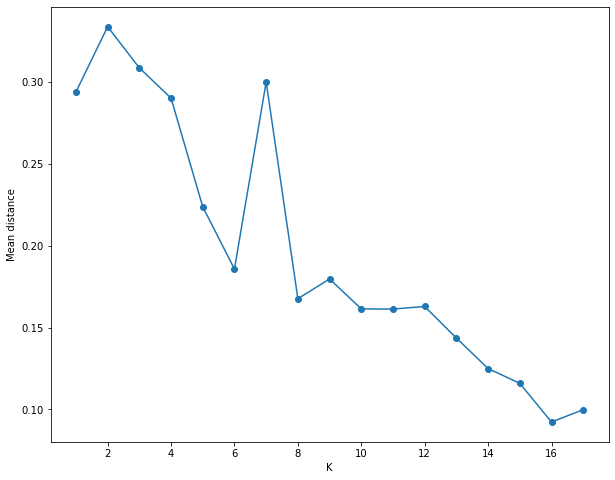

In [45]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(range(1,n_clusters),tot_avg_distance,marker='o')
ax.set_xlabel('K')
ax.set_ylabel("Mean distance")
plt.show()

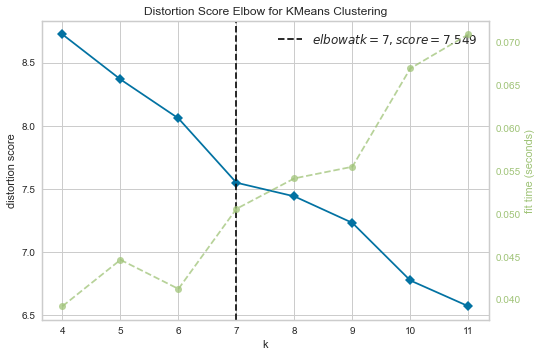

In [46]:
# We can also use the KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), locate_elbow = True)

visualizer.fit(gym_venues_clustering)        # Fit the data to the visualizer
visualizer.show()

In [36]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(gym_venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 6, 1, 1, 1, 1, 1])

In [48]:
print('Count of all lablels: {} label'.format(len(kmeans.labels_))) # Should be equal to the number of gyms
print('The number of gyms found is: {} gyms'.format(len(gym_venues_df['Gym id'].unique())))

Count of all lablels: 96 label
The number of gyms found is: 96 gyms


In [49]:
# gym_venues_grouped.head()

In [37]:
# Building a dataframe with the gym name, id, latitude, longitude, likes count, rating as well as the newly found cluster label:
gym_clustered = gym_venues_grouped[list(gym_venues_grouped.columns[:7])]

gym_clustered.insert(len(gym_clustered.columns),'Clustering Labels', kmeans.labels_)

gym_clustered.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,Clustering Labels
0,YM-YWHA Montreal Jewish Community Centres - Be...,Gym,4ad4c06cf964a520f1f920e3,45.488306,-73.634512,13,8.1,1
1,YM-YWHA Montreal Jewish Community Centres - Be...,Gym,4ae47814f964a520c49a21e3,45.499562,-73.574618,122,8.2,1
2,YM-YWHA Montreal Jewish Community Centres - Be...,Gym,4af0e9e8f964a52016e021e3,45.440404,-73.621673,11,6.5,1
3,YM-YWHA Montreal Jewish Community Centres - Be...,Gym,4af89924f964a520960e22e3,45.519636,-73.587275,45,6.2,1
4,YM-YWHA Montreal Jewish Community Centres - Be...,Gym,4b0033ddf964a520793b22e3,45.489494,-73.693481,8,6.8,6


Text(0, 0.5, 'Frequency')

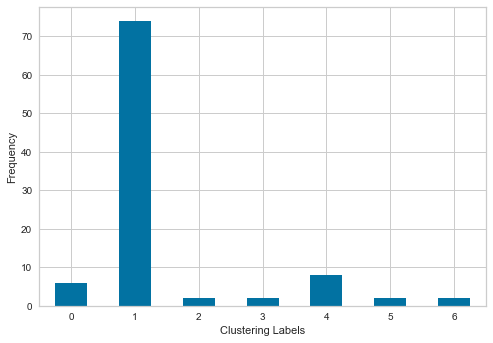

In [51]:
# Look at the size of each cluster:

gym_clustered.groupby('Clustering Labels').count()['Gym id'].plot(kind = 'bar')
plt.xticks(rotation=0)
plt.ylabel('Frequency')

In [52]:
gym_clustered.groupby('Clustering Labels').count()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating
Clustering Labels,,,,,,,
0,6,6,6,6,6,6,6
1,74,74,74,74,74,74,74
2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2
4,8,8,8,8,8,8,8
5,2,2,2,2,2,2,2
6,2,2,2,2,2,2,2


In [53]:
# Generating montreal map:
mtl_map = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, name, cat, cluster in zip(gym_clustered['Gym lat'],gym_clustered['Gym lng'], gym_clustered['Gym Name'], gym_clustered['Gym category'], gym_clustered['Clustering Labels']):
    label = '{}, ({})'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    try:
        color=venue_colormap[cat]
    except:
        color='grey'
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color = color, # The border color defines the type of the training center (gym, boxing club, mma, etc ...)
        color_opacity = 0.5,
        fill=True,
        fill_color=rainbow[cluster-1], # The fill color is used to distinguish clusters
        fill_opacity=1,
        parse_html=False).add_to(mtl_map)

mtl_map

## Clusters' Analysis :
### Defining features of each cluster - looking at the most common surrounding venues:

In [54]:
# Group by each cluster the nearby venues. Then look at the top 10 most common venues for cluster. 

In [38]:
clusters_grouped = gym_venues_grouped[gym_venues_grouped.columns[7:]]
clusters_grouped.insert(0,'Clustering Labels', kmeans.labels_)

In [39]:
clusters_grouped = clusters_grouped.groupby('Clustering Labels').mean().reset_index()

In [57]:
clusters_grouped

,Clustering Labels,ATM,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Football Field,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse 

In [40]:
# Building the empty dataframe that will contain the most common 'n' venues:

n = 10 # Venues number to consider in the analysis
columns = []

for nn in range(1,n+1):
    if nn == 1:
        columns.append('1st Most Common Venue')
    elif nn == 2:
        columns.append('2nd Most Common Venue')
    elif nn == 3:
        columns.append('3rd Most Common Venue')
    else:
        columns.append(str(nn) + 'th Most Common Venue')

clusters_most_common_venues = pd.DataFrame(columns=columns)

In [41]:
# Looping through the dataframe with the grouped clusters. For each row, each cluster, we order the venues by descending order and take the first 'n' venues. Then we append the ordered venues to the dataframe.
for i in range(kclusters):
    temp = pd.DataFrame(clusters_grouped.iloc[i,1:].sort_values(ascending=False).head(n)).transpose()
    clusters_most_common_venues.loc[i]= temp.columns

In [42]:
clusters_most_common_venues

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Fast Food Restaurant,Convenience Store,Gym / Fitness Center,Grocery Store,Sandwich Place,Breakfast Spot,Gas Station,Bowling Alley,Board Shop,Gift Shop
1,Coffee Shop,Café,Restaurant,Fast Food Restaurant,Pharmacy,Breakfast Spot,Pizza Place,Bakery,Vietnamese Restaurant,Gym
2,Construction & Landscaping,Sandwich Place,Hockey Arena,Restaurant,Asian Restaurant,Convenience Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
3,Park,Cosmetics Shop,Brewery,Movie Theater,Fish & Chips Shop,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
4,Pizza Place,Grocery Store,Pharmacy,Gym / Fitness Center,Convenience Store,Italian Restaurant,Women's Store,Museum,Mediterranean Restaurant,Ice Cream Shop
5,Park,Gourmet Shop,Comedy Club,Bakery,Soccer Field,Fast Food Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market
6,Furniture / Home Store,Gym,Scandinavian Restaurant,Sports Bar,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market


### Conclusion - this conclusion applies to the results obtained with the data available at the moment of creating this notebook. With more data the conclusions might change:
Looking at the most common venues in each cluster we note the following:
* The clusters with most elements are the clusters under labels 0 and 4
* When we look closely at these clusters we notice that the main venue categories surrounding the elements of the clusters 0 and 4 are in the food industry either a grocery store, coffee shop, bakery, fast food restaurant or any type of restaurant.
* Maybe this type of nearby venue is a good way to attract people and should be considered in the location selection. Especially for coffe shops and Cafe as they seem to be exclusively present in cluster 1.


### Is there a relationship between rating and clusters/ Near by venues:

In [43]:
# Sorting training centers by order of descending ratings:
top_rated_gym_venues = gym_venues_grouped[gym_venues_grouped['Rating']!=-1].sort_values(by='Rating',ascending=False)

top_rated_gym_venues.head()

,Gym Name,Gym category,Gym id,Gym lat,Gym lng,Likes count,Rating,ATM,Adult Boutique,Airport Service,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cambodian Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Football Field,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hockey Arena,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Sausage Shop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Soccer Field,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Stor

In [44]:
# Thought about adding a metric that uses both Ratings and Likes count together to order the training centers instead of just using ratings or Likes count
gym_clustered['Succes metric'] = abs(gym_clustered['Rating']*gym_clustered['Likes count'])

In [45]:
# Let us go back using the top_rated_gyms dataframe. 

# How many gyms do you want to consider:
n_gyms = 20
# top_rated_gyms = gym_clustered[gym_clustered['Rating']!=-1].head(n_gyms).sort_values(by='Succes metric',ascending=False)

# Building a dataframe containing the top rated training centers without the nearby venues:
top_rated_gyms = gym_clustered[gym_clustered['Likes count']!=0]
top_rated_gyms = top_rated_gyms[top_rated_gyms['Rating']!=-1] 

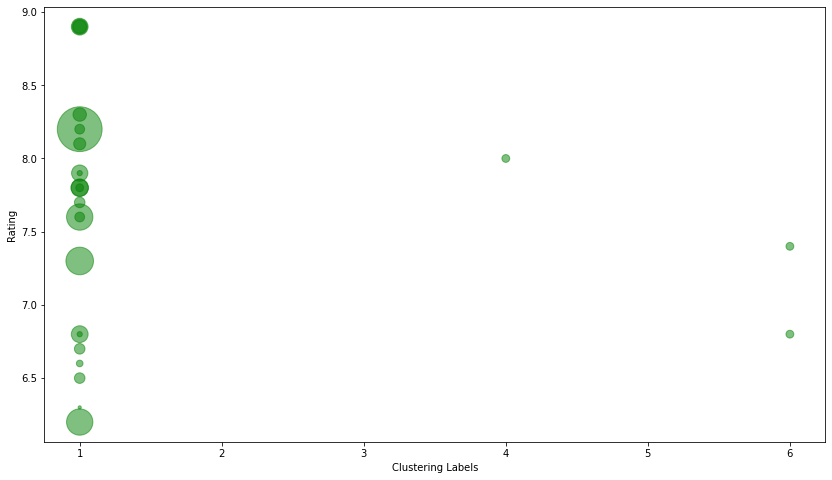

In [47]:
# Normalizing the likes count to use as weights in the bubble plot.
norm_likes =(top_rated_gyms['Likes count'] - top_rated_gyms['Likes count'].min())/(top_rated_gyms['Likes count'].max() - top_rated_gyms['Likes count'].min())

# Plot ratings vs cluster label - The size of the bubbles is proportional to the likes count:
top_rated_gyms.plot(kind='scatter',
                    x='Clustering Labels',
                    y='Rating',
                    # y='Succes metric',
                    figsize=(14, 8),
                    alpha=0.5, # transparency
                    color='green',
                    s=norm_likes*2000  + 10  # pass in the weights
                    )

### Comments:
* First we notice that the majority of rated venues belong exclusively to clusters 1.
* The presence/ absence of ratings alone can be considered as an indicator (a weak one however) of the popularity of the gym center : 
    * Availability of the data shows that it is a fairly frequented venue. 
    * Absence of data is an indication of the opposite   
#### The clustering analysis is showing that the surrounding venues to be considered should be similar to those of cluster 1

## Finding areas of interest:
In this section we will explore the city of Montreal and select areas that respect the following criteria:
* Nearby venues (the 10 most common venues) similar to those of cluster 1 in a 500m radius.
* Maximum of one gym in the vicinity (500m radius)
* Maximum of 2 nearby martial arts training center (500m radius) 

In [48]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Montreal center longitude={}, latitude={}'.format(longitude_mtl, latitude_mtl))
x, y = lonlat_to_xy(longitude_mtl, latitude_mtl)
print('Montreal center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Montreal center longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
Montreal center longitude=-73.6103642, latitude=45.4972159
Montreal center UTM X=-5044740.530060252, Y=9846019.381976191
Montreal center longitude=-73.61036419999989, latitude=45.49721589999976


In [49]:
address = 'Ville de Mont Royal, Montreal'

geolocator = Nominatim(user_agent="mtl_explorer")
location = geolocator.geocode(address)
longitude_mtl = location.longitude
latitude_mtl = location.latitude

In [52]:

mtl_center_x, mtl_center_y = lonlat_to_xy(longitude_mtl, latitude_mtl) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells

search_radius = 25000 # radius of the area to be segmented
pocket_radius = 500 # Radius of each of pocket
num_iter = int(search_radius/pocket_radius) + 1 # number of circles required to cover the distance of our search radius

x_min = mtl_center_x - search_radius
x_step = pocket_radius * 2
y_min = mtl_center_y - int(num_iter/k)*k*pocket_radius
# y_min = mtl_center_y - num_iter*pocket_radius
y_step = pocket_radius * 2 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(num_iter/k)):
    y = y_min + i * y_step
    x_offset = pocket_radius if i%2==0 else 0
    for j in range(0, num_iter):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(mtl_center_x, mtl_center_y, x, y)
        if (distance_from_center <= search_radius + 1):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

2265 candidate neighborhood centers generated.


In [54]:
map_mtl = folium.Map(location=[latitude_mtl, longitude_mtl], zoom_start=11)
folium.Marker([latitude_mtl, longitude_mtl], popup='Montreal center').add_to(map_mtl)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=pocket_radius, color='blue', fill=False).add_to(map_mtl)
    # folium.Marker([lat, lon]).add_to(map_mtl)lat, lon = [latitudes[4], longitudes[4]]
folium.Marker([latitudes[2163], longitudes[2163]], popup='Montreal center').add_to(map_mtl)
map_mtl

In [69]:
if not load:
    venues_LIMIT = 300

    pocket_filtered_columns = ['venue.name', 'venue.categories']

    pocket_nearby_venues_df = pd.DataFrame()

    empty_venues = []
    for lat, lon in zip(latitudes, longitudes):
        # lat, lon = [latitudes[0], longitudes[0]]
        print(latitudes.index(lat),end='.')
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, pocket_radius, venues_LIMIT)

        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        if venues:
            pocket_nearby_venues = json_normalize(venues)


            pocket_nearby_venues = pocket_nearby_venues[pocket_filtered_columns]
            pocket_nearby_venues['venue.categories'] = pocket_nearby_venues.apply(get_category_type,axis=1)

            pocket_nearby_venues.columns = map(str.title,[col_name.split('.')[-1] for col_name in pocket_nearby_venues.columns])

            pocket_nearby_venues.rename(columns={'Name':'Venue Name'}, inplace=True)

            pocket_nearby_venues['Pocket'] = latitudes.index(lat)

            pocket_nearby_venues_df = pocket_nearby_venues_df.append(pocket_nearby_venues)
        else:
            empty_venues.append(latitudes.index(lat))
    
    column_order = list(pocket_nearby_venues_df.columns[-1:]) + list(pocket_nearby_venues_df.columns[:-1])
    pocket_nearby_venues_df = pocket_nearby_venues_df[column_order]

    pocket_nearby_venues_df.to_pickle('./pocket_nearby_venues.pkl')

In [70]:
# lat, lon = [latitudes[2163], longitudes[2163]]
# url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, pocket_radius, venues_LIMIT)

# results = requests.get(url).json()
# venues = results['response']['groups'][0]['items']

# if venues:
#     pocket_nearby_venues = json_normalize(venues)


#     pocket_nearby_venues = pocket_nearby_venues[pocket_filtered_columns]
#     pocket_nearby_venues['venue.categories'] = pocket_nearby_venues.apply(get_category_type,axis=1)

#     pocket_nearby_venues.columns = map(str.title,[col_name.split('.')[-1] for col_name in pocket_nearby_venues.columns])

#     pocket_nearby_venues.rename(columns={'Name':'Venue Name'}, inplace=True)

#     pocket_nearby_venues['Pocket'] = latitudes.index(lat)

#     pocket_nearby_venues_df = pocket_nearby_venues_df.append(pocket_nearby_venues) 

In [71]:
# pocket_nearby_venues_df.head()
# venues

In [55]:
if load:
    with open('./pocket_nearby_venues.pkl', 'rb') as f:
        pocket_nearby_venues_df = pickle.load(f) 
pocket_nearby_venues_df.head()

,Pocket,Venue Name,Categories
0,0,Adonis,Grocery Store
1,0,SAIL,Outdoor Supply Store
2,0,Avril Supermarché Santé,Organic Grocery
3,0,Mr Puffs,Dessert Shop
4,0,Mitsuki,Sushi Restaurant


In [73]:
pocket_nearby_venues_df.head()
# pocket_nearby_venues_df.shape

,Pocket,Venue Name,Categories
0,0,Adonis,Grocery Store
1,0,SAIL,Outdoor Supply Store
2,0,Avril Supermarché Santé,Organic Grocery
3,0,Mr Puffs,Dessert Shop
4,0,Mitsuki,Sushi Restaurant


In [74]:
# pocket_nearby_venues_df.groupby('Categories').count()
# pocket_nearby_venues_df['Categories'].unique()
# pocket_nearby_venues_df['Pocket'].unique()

In [75]:
pocket_nearby_venues_df_onehot = pd.get_dummies(pocket_nearby_venues_df[['Categories']], prefix="", prefix_sep="")
# pocket_nearby_venues_df_onehot.head()
pocket_nearby_venues_df_onehot = pd.concat([pocket_nearby_venues_df[pocket_nearby_venues_df.columns[0]],pocket_nearby_venues_df_onehot],axis=1)

In [76]:
pocket_nearby_venues_df_onehot_grouped = pocket_nearby_venues_df_onehot.groupby('Pocket').mean().reset_index()
pocket_nearby_venues_df_onehot_grouped.head()

,Pocket,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Alternative Healer,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Gym,College Hockey Rink,College Rec Center,College Soccer Field,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Currency Exchange,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Stor

In [90]:
pockets_most_common_venues = pd.DataFrame(columns=columns)
for index, row in pocket_nearby_venues_df_onehot_grouped.iterrows():
    print(' .',end='')
    temp = pd.DataFrame(pocket_nearby_venues_df_onehot_grouped.iloc[index,1:].sort_values(ascending=False).head(n)).transpose()
    pockets_most_common_venues.loc[index]= temp.columns

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [92]:
pockets_most_common_venues.head(100)
# temp = pd.DataFrame(pocket_nearby_venues_df_onehot_grouped.iloc[0,1:].sort_values(ascending=False).head(n)).transpose()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Electronics Store,Organic Grocery,Dessert Shop,Gas Station,Sushi Restaurant,Grocery Store,Big Box Store,BBQ Joint,Outdoor Supply Store,Discount Store
1,Gas Station,Construction & Landscaping,Park,Asian Restaurant,Bus Line,Zoo,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
2,Park,Playground,Zoo,Factory,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
3,Playground,Bank,Park,Auto Garage,Fabric Shop,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
4,Health & Beauty Service,Convenience Store,Italian Restaurant,Home Service,Playground,Zoo,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room
5,Playground,Zoo,Falafel Restaurant,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space
6,Soccer Field,Business Service,Pizza Place,Zoo,Fabric Shop,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
7,Construction & Landscaping,Zoo,Falafel Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor
8,Big Box Store,Intersection,Sandwich Place,Fast Food Restaurant,Board Shop,Train Station,Shoe Store,Soccer Field,Convenience Store,Brewery
9,Park,Airport,Soccer Field,Zoo,Factory,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant


### Ideas for analysis:

In [79]:
# - Once some type of criteria is defined we can then look at different neighbourhoods in montreal to see which ones fit the criteria.
# - Find data on the price of rent by location and plot a chloropleth map displaying the data.

# - Look at the demographic of the muslim community
# - Look at real state prices geographically 